In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

import simcube

from simcube.data import \
    tokenize_corpus, \
    build_vocabulary, \
    texts_to_token_ids, \
    PaddedSequenceDataset, \
    Embeddings

from simcube.pipeline import \
    train_eval_loop, \
    predict_with_model, \
    init_random_seed

from simcube.visualization import plot_vectors

from tqdm import tqdm
from pymongo import MongoClient

init_random_seed()

plt.rcParams["figure.figsize"] = (15,10)

## Загрузка данных и подготовка корпуса

In [2]:
client = MongoClient('localhost', 27017)
db = client.publicru_test
collection = db.documents_collection

In [3]:
mongo_filter = {
    "t_title": {"$exists": True},
    "t_body": {"$exists": True},
    "edition_name": { "$in": ["РБК Журнал", "Российская газета"]},
#     "words_count": {"$gt": 300},
}

collection.count_documents(mongo_filter)

59959

In [4]:
documents = collection.find(mongo_filter, {"t_body": 1}, no_cursor_timeout=True)
full_dataset = []
for document in tqdm(collection.find(mongo_filter, {"t_body": 1}, no_cursor_timeout=True)):
    for para in document["t_body"][0]:
        for sent in para:
            if len(sent) > 5:
                full_dataset.append(" ".join(sent))

59959it [00:11, 5154.49it/s]


In [5]:
full_dataset[0]

'взять_V компания_S сопоставимый_A выручка_S оценивать_V влияние_S курс_S рубль_S финансы_S'

In [6]:
print("\n".join(full_dataset[:10]))

взять_V компания_S сопоставимый_A выручка_S оценивать_V влияние_S курс_S рубль_S финансы_S
участник_S производитель_S удобрение_S фосагро_S большой_A часть_S выручка_S получать_V экспорт_S
участник_S ориентировать_V внутренний_A рынок_S компания_S видео_S продавать_V электроника_S техника_S
качество_S отчет_S взять_V курс_S рубль_S доллар_S оставаться_V стабильный_A находиться_V диапазон_S
индекс_S потребительский_A цена_S товар_S услуга_S российский_A федерация_S апрель_S июнь_S
цена_S продукт_S следить_V сайт_S rg ru sujet
единый_A медицинский_A информационный_A аналитический_A система_S емиас_S пользоваться_V москвич_S
цифра_S называть_V мэр_S столица_S сергей_S собянин_S посещать_V ситуационный_A центр_S департамент_S здравоохранение_S
помощь_S емиас_S легко_ADV находить_V близкий_A дом_S поликлиника_S получать_V справка_S льготный_A рецепт_S
большинство_S горожанин_S слово_S градоначальник_S использовать_V система_S запись_S врач_S


In [7]:
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.7)
train_source = full_dataset[:TRAIN_VAL_SPLIT]
test_source = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_source))
print("Тестовая выборка", len(test_source))
print()
print('\n'.join(train_source[:10]))

Обучающая выборка 1041324
Тестовая выборка 446283

останки_S состоять_V основное_S минерал_S пирит_S пронизывать_V мелкий_A
клевер_S памятный_A доска_S эдуард_S васильевич_S толль_S первооткрыватель_S арктика_S
большинство_S игра_S жанр_S стратегия_S заниматься_V управление_S ресурс_S постройка_S город_S
набираться_V административный_A практика_S понятно_ADV работать_V норма_S говорить_V дополнительный_A наказание_S
иначе_CONJ получаться_V принятый_A закон_S исполняться_V настаивать_V зотов_S
пояснительный_A записка_S документ_S случай_S неисполнение_S осужденный_S обязанность_S суд_S принимать_V решение_S отмена_S условный_A осуждение_S исполнение_S наказание_S продлять_V испытательный_A срок_S применять_V условно_ADV досрочный_A освобождение_S отбывание_S наказание_S заменять_V неотбытый_A часть_S наказание_S мягкий_A вид_S наказание_S
слово_S хороший_A бомбардир_S отбор_S южный_A америка_S уругваец_S эдинсон_S кавань_S забивать_V мяч_S
введение_S нацеливать_V активный_A развитие_S в

In [8]:
# Дистрибутивная семантика
# эта наука занимается изучением смыслов слов
# Смысл слова описывается тем контестом, в котором слово обычно употребляется

# Методы дистрибутивной семантики пытаются извлечь смысл слов, анализируя распределения
# вероятностей совместной встречаемости слов в рамках одго фрагмента текста 
# или вероятностей встретить одни слова в контексте других

In [9]:
# токенизируем
train_tokenized = tokenize_corpus(train_source)
test_tokenized = tokenize_corpus(test_source)
print('\n'.join(' '.join(sent) for sent in train_tokenized[:10]))

останки_s состоять_v основное_s минерал_s пирит_s пронизывать_v мелкий_a
клевер_s памятный_a доска_s эдуард_s васильевич_s толль_s первооткрыватель_s арктика_s
большинство_s игра_s жанр_s стратегия_s заниматься_v управление_s ресурс_s постройка_s город_s
набираться_v административный_a практика_s понятно_adv работать_v норма_s говорить_v дополнительный_a наказание_s
иначе_conj получаться_v принятый_a закон_s исполняться_v настаивать_v зотов_s
пояснительный_a записка_s документ_s случай_s неисполнение_s осужденный_s обязанность_s суд_s принимать_v решение_s отмена_s условный_a осуждение_s исполнение_s наказание_s продлять_v испытательный_a срок_s применять_v условно_adv досрочный_a освобождение_s отбывание_s наказание_s заменять_v неотбытый_a часть_s наказание_s мягкий_a вид_s наказание_s
слово_s хороший_a бомбардир_s отбор_s южный_a америка_s уругваец_s эдинсон_s кавань_s забивать_v мяч_s
введение_s нацеливать_v активный_a развитие_s внутренний_a производство_s санкция_s ускорять_v про

In [10]:
# строим словарь
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=0.9, min_count=5, pad_word='<PAD>')
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 57447
[('<PAD>', 0), ('россия_s', 1), ('новый_a', 2), ('российский_a', 3), ('страна_s', 4), ('становиться_v', 5), ('работа_s', 6), ('компания_s', 7), ('получать_v', 8), ('проект_s', 9)]


In [11]:
# отображаем в номера токенов
train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)

print('\n'.join(' '.join(str(t) for t in sent) for sent in train_token_ids[:10]))

6065 1332 3019 11923 10126 2295
26127 4493 4240 4577 6840 48103 18944 2387
305 215 2690 1044 251 170 515 3568 27
7387 658 480 1359 31 551 104 285 830
1541 634 4211 43 2922 2358 14434
4388 3318 86 37 5964 2469 1081 32 20 17 1978 3715 9741 752 830 2390 6741 131 1111 3702 3452 2502 10354 830 1536 51 830 3123 95 830
26 62 4017 2176 854 1230 21173 26128 20826 1644 1191
954 3255 721 15 447 105 614 3020 185
618 462 104 1179 607 411 811 6451
712 348 8360 5121 81 656 780 98 3174 838 72 2000 7467 1552 6 1638 8 672 31 753 220 1447 176 2987 1447


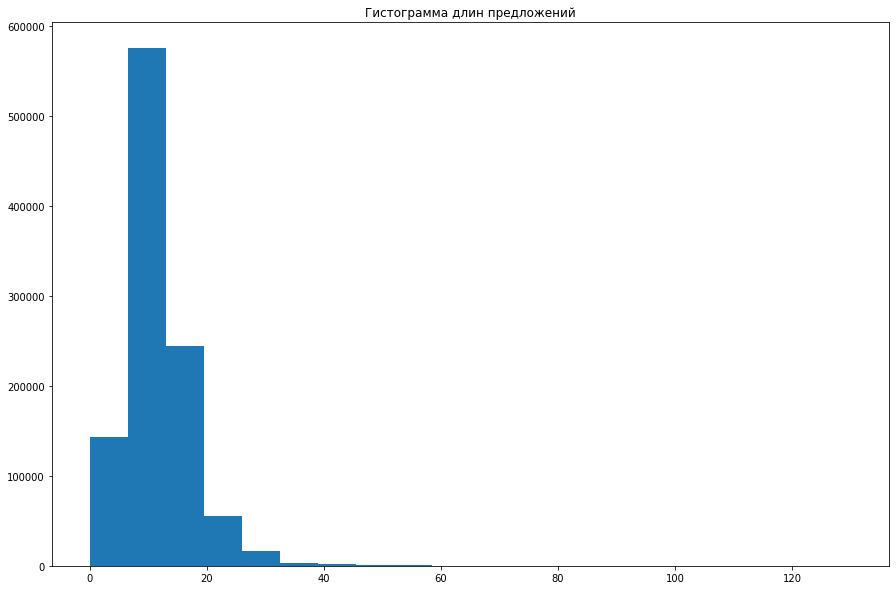

In [12]:
plt.hist([len(s) for s in train_token_ids], bins=20);
plt.title('Гистограмма длин предложений');

In [13]:
MAX_SENTENCE_LEN = 40
train_dataset = PaddedSequenceDataset(train_token_ids,
                                      np.zeros(len(train_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
test_dataset = PaddedSequenceDataset(test_token_ids,
                                     np.zeros(len(test_token_ids)),
                                     out_len=MAX_SENTENCE_LEN)

In [14]:
print(train_dataset[0])

(tensor([ 6065,  1332,  3019, 11923, 10126,  2295,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), tensor(0))


In [15]:
print(train_dataset[1])

(tensor([26127,  4493,  4240,  4577,  6840, 48103, 18944,  2387,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), tensor(0))


## Алгоритм обучения - Skip Gram Negative Sampling

In [16]:
# Skip Gram - моделирует распределение соседей при условии центрального слова
# CBOW, continuous bag of words - моделирует распределение центрального слова при условии известных соседей

In [17]:
# Skip Gram - предсказываем соседние слова по центральному слову
# Negative Sampling - аппроксимация softmax

In [18]:
def make_diag_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

In [19]:
make_diag_mask(10, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

In [26]:
class SkipGramNegativeSamplingTrainer(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0

        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        self.positive_sim_mask = make_diag_mask(sentence_len, radius)
    
    def forward(self, sentences):
        """sentences - Batch x MaxSentLength - идентификаторы токенов"""
        batch_size = sentences.shape[0]
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        # оценить сходство с настоящими соседними словами
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        positive_probs = torch.sigmoid(positive_sims)

        # увеличить оценку вероятности встретить эти пары слов вместе
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))

        # выбрать случайные "отрицательные" слова
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
        # уменьшить оценку вероятность встретить эти пары слов вместе
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

        return positive_loss + negative_loss


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

In [21]:
# class SkipGramNegativeSamplingTrainer(nn.Module):
#     def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
#         super().__init__()
#         self.vocab_size = vocab_size
#         self.negative_samples_n = negative_samples_n

#         self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
#         self.center_emb.weight.data[0] = 0

#         self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
#         self.context_emb.weight.data[0] = 0

#         self.positive_sim_mask = make_diag_mask(sentence_len, radius)
    
#     def forward(self, sentences):
#         """sentences - Batch x MaxSentLength - идентификаторы токенов"""
#         batch_size = sentences.shape[0]
#         center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

#         # оценить сходство с настоящими соседними словами
#         positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
#         positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
#         positive_probs = torch.sigmoid(positive_sims)

#         # увеличить оценку вероятности встретить эти пары слов вместе
#         positive_mask = self.positive_sim_mask.to(positive_sims.device)
#         positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
#                                                positive_mask.expand_as(positive_probs))

#         # выбрать случайные "отрицательные" слова
#         negative_words = torch.randint(1, self.vocab_size,
#                                        size=(batch_size, self.negative_samples_n),
#                                        device=sentences.device)  # Batch x NegSamplesN
#         negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
#         negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
#         # уменьшить оценку вероятность встретить эти пары слов вместе
#         negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
#                                                            negative_sims.new_zeros(negative_sims.shape))

#         return positive_loss + negative_loss


# def no_loss(pred, target):
#     """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
#     return pred

## Обучение

In [27]:
EMBEDDING_SIZE = 300

In [28]:
trainer = SkipGramNegativeSamplingTrainer(
    len(vocabulary), 
    EMBEDDING_SIZE, 
    MAX_SENTENCE_LEN, 
    radius=7, 
    negative_samples_n=50
)

In [39]:
%%time

best_val_loss, best_model = train_eval_loop(trainer, train_dataset, test_dataset,
    no_loss,
    lr=1e-2,
    epoch_n=100,
    batch_size=4096,
    early_stopping_patience=10,
    max_batches_per_epoch_train=2000,
    max_batches_per_epoch_val=len(test_dataset),
    lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True)
)

Выбранное устройство: cuda
Эпоха 0
Эпоха: 255 итераций, 40.19 сек
Среднее значение функции потерь на обучении 0.7325544319900812
Среднее значение функции потерь на валидации 0.7415887237688817
Новая лучшая модель!

Эпоха 1
Эпоха: 255 итераций, 40.05 сек
Среднее значение функции потерь на обучении 0.7318872683188494
Среднее значение функции потерь на валидации 0.7420475953215853

Эпоха 2
Эпоха: 255 итераций, 40.42 сек
Среднее значение функции потерь на обучении 0.7314481344877505
Среднее значение функции потерь на валидации 0.7425029086410453
Epoch     3: reducing learning rate of group 0 to 1.0000e-03.

Эпоха 3
Эпоха: 255 итераций, 41.05 сек
Среднее значение функции потерь на обучении 0.7289955314467935
Среднее значение функции потерь на валидации 0.742123155418886

Эпоха 4
Эпоха: 255 итераций, 40.06 сек
Среднее значение функции потерь на обучении 0.7285354135083217
Среднее значение функции потерь на валидации 0.7421506577675495
Epoch     5: reducing learning rate of group 0 to 1.0000e

In [45]:
torch.save(trainer.state_dict(), '../../data/models/word2vec_publicru.pth')

In [127]:
trainer.load_state_dict(torch.load('../../data/models/word2vec_publicru.pth'))

<All keys matched successfully>

## Исследуем характеристики полученных векторов

In [40]:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [141]:
embeddings.most_similar('производство_s')

[('производство_s', 0.99989825),
 ('проект_s', 0.6965773),
 ('новый_a', 0.6931054),
 ('компания_s', 0.68513983),
 ('рынок_s', 0.6801111),
 ('число_s', 0.6506296),
 ('отмечать_v', 0.6376673),
 ('позволять_v', 0.6146303),
 ('объем_s', 0.60660666),
 ('россия_s', 0.60497177)]

In [41]:
embeddings.most_similar('производство_s')

[('производство_s', 0.99992096),
 ('продукция_s', 0.55626273),
 ('завод_s', 0.5547482),
 ('предприятие_s', 0.5505022),
 ('производить_v', 0.5178776),
 ('производственный_a', 0.4896776),
 ('производитель_s', 0.48269948),
 ('сырье_s', 0.48120585),
 ('переработка_s', 0.457134),
 ('промышленность_s', 0.4427635)]

In [142]:
embeddings.most_similar('суд_s')

[('суд_s', 0.9999099),
 ('дело_s', 0.7067026),
 ('решение_s', 0.6923086),
 ('рф_s', 0.6211534),
 ('закон_s', 0.60568774),
 ('судебный_a', 0.5873336),
 ('право_s', 0.58008456),
 ('действие_s', 0.560911),
 ('гражданин_s', 0.55038774),
 ('организация_s', 0.5423951)]

In [143]:
embeddings.most_similar('договор_s')

[('договор_s', 0.9999314),
 ('соглашение_s', 0.46501383),
 ('судебный_a', 0.46444285),
 ('право_s', 0.45400074),
 ('условие_s', 0.44812977),
 ('гражданин_s', 0.44400352),
 ('объект_s', 0.44157922),
 ('вносить_v', 0.4402086),
 ('документ_s', 0.43393815),
 ('изменение_s', 0.43317464)]

In [144]:
embeddings.most_similar('цена_s')

[('цена_s', 0.99991095),
 ('составлять_v', 0.64057887),
 ('рост_s', 0.5865109),
 ('рынок_s', 0.57883406),
 ('начинать_v', 0.57772124),
 ('процент_s', 0.5711404),
 ('высокий_a', 0.5706242),
 ('предлагать_v', 0.566959),
 ('эксперт_s', 0.563359),
 ('новый_a', 0.56243986)]

In [44]:
embeddings.most_similar('цена_s')

[('цена_s', 0.9999309),
 ('стоимость_s', 0.6015996),
 ('инфляция_s', 0.4860628),
 ('рост_s', 0.47687057),
 ('рынок_s', 0.46634704),
 ('спрос_s', 0.46138352),
 ('снижение_s', 0.45430446),
 ('тариф_s', 0.44423985),
 ('покупатель_s', 0.43533558),
 ('производитель_s', 0.4250661)]

In [42]:
embeddings.most_similar('суд_s')

[('суд_s', 0.9999281),
 ('верховный_a', 0.63530284),
 ('судебный_a', 0.6089958),
 ('инстанция_s', 0.5771936),
 ('районный_a', 0.56623435),
 ('иск_s', 0.5398433),
 ('апелляционный_a', 0.5025004),
 ('судья_s', 0.49741238),
 ('арбитражный_a', 0.476968),
 ('приговор_s', 0.46362615)]

In [43]:
embeddings.most_similar('договор_s')

[('договор_s', 0.9999368),
 ('заключать_v', 0.62913454),
 ('заключение_s', 0.50120175),
 ('купля_s', 0.48982334),
 ('обязательство_s', 0.4828233),
 ('соглашение_s', 0.42113838),
 ('подписывать_v', 0.41189706),
 ('куплипродажа_s', 0.4113573),
 ('аренда_s', 0.39903152),
 ('подписание_s', 0.3865553)]

In [121]:
embeddings.most_similar('президент_s')

[('президент_s', 0.9999025),
 ('россия_s', 0.79454213),
 ('российский_a', 0.75110555),
 ('вопрос_s', 0.7180869),
 ('международный_a', 0.7140336),
 ('отношение_s', 0.70525396),
 ('страна_s', 0.6916815),
 ('отмечать_v', 0.6852909),
 ('рф_s', 0.68009293),
 ('регион_s', 0.66130936)]

In [123]:
embeddings.analogy('президент_s', 'рф_s', "договор_s")

[('договор_s', 1.0735238),
 ('рф_s', 0.64621836),
 ('суд_s', 0.5998943),
 ('судебный_a', 0.5971396),
 ('гражданин_s', 0.5768467),
 ('закон_s', 0.54642963),
 ('право_s', 0.5317962),
 ('объект_s', 0.52672124),
 ('иной_apro', 0.52620685),
 ('услуга_s', 0.5200727)]

In [32]:
test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 
              'cake', 'coffee', 'sausage', 'wine', 'merlot', 'zinfandel', 
              'trout', 'chardonnay', 'champagne', 'cacao']
test_vectors = embeddings.get_vectors(*test_words)
print(test_vectors.shape)

(18, 100)


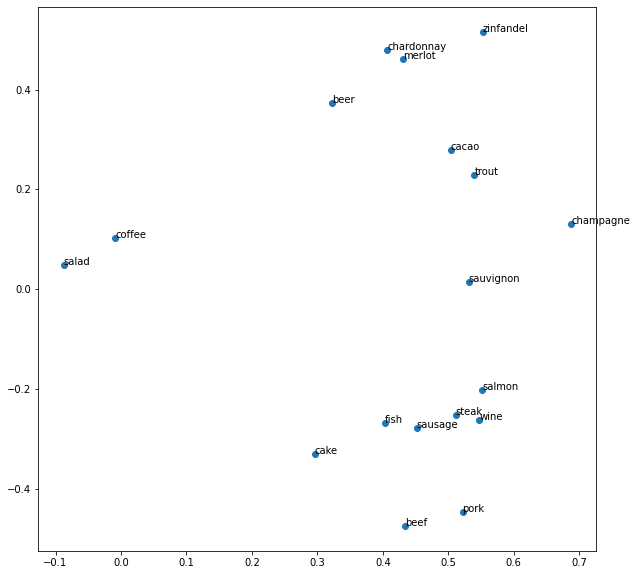

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)

## Обучение Word2Vec с помощью Gensim

In [124]:
import gensim

In [128]:
%%time

word2vec = gensim.models.Word2Vec(
    sentences=train_tokenized, 
    size=EMBEDDING_SIZE,
    window=5, 
    min_count=5, 
    workers=24,
    sg=1, 
    iter=10
)

CPU times: user 24min 1s, sys: 2.42 s, total: 24min 3s
Wall time: 2min 27s


In [37]:
word2vec.wv.most_similar('chicken')

[('duck', 0.7388399839401245),
 ('thighs', 0.7044893503189087),
 ('pheasant', 0.693988025188446),
 ('simmering', 0.6856342554092407),
 ('drumsticks', 0.682977557182312),
 ('turkey', 0.6816940903663635),
 ('defatted', 0.6567668914794922),
 ('breasts', 0.6559194326400757),
 ('rabbit', 0.6544360518455505),
 ('chickens', 0.6531239748001099)]

In [38]:
word2vec.wv.most_similar('coffee')

[('espresso', 0.871442437171936),
 ('brewed', 0.7680679559707642),
 ('instant', 0.6789559721946716),
 ('process', 0.6784331798553467),
 ('grinder', 0.6719653010368347),
 ('spices', 0.6662553548812866),
 ('west', 0.6434237957000732),
 ('garam', 0.6430879831314087),
 ('dutch', 0.6400915384292603),
 ('sweetened', 0.6370556354522705)]

In [39]:
gensim_words = [w for w in test_words if w in word2vec.wv.vocab]
gensim_vectors = np.stack([word2vec.wv[w] for w in gensim_words])

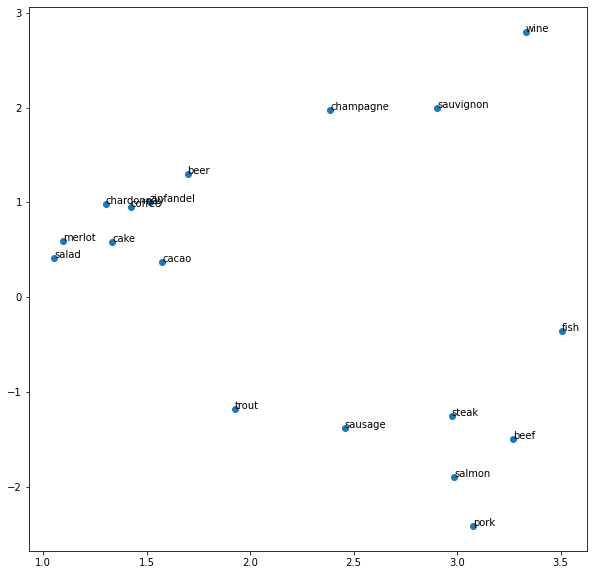

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)

## Загрузка предобученного Word2Vec

Источники готовых векторов:

https://rusvectores.org/ru/ - для русского языка

https://wikipedia2vec.github.io/wikipedia2vec/pretrained/ - много разных языков

In [42]:
import gensim.downloader as api

In [43]:
available_models = api.info()['models'].keys()
print('\n'.join(available_models))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [44]:
api.info()

{'corpora': {'semeval-2016-2017-task3-subtaskBC': {'num_records': -1,
   'record_format': 'dict',
   'file_size': 6344358,
   'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/semeval-2016-2017-task3-subtaskB-eng/__init__.py',
   'license': 'All files released for the task are free for general research use',
   'fields': {'2016-train': ['...'],
    '2016-dev': ['...'],
    '2017-test': ['...'],
    '2016-test': ['...']},
   'description': 'SemEval 2016 / 2017 Task 3 Subtask B and C datasets contain train+development (317 original questions, 3,169 related questions, and 31,690 comments), and test datasets in English. The description of the tasks and the collected data is given in sections 3 and 4.1 of the task paper http://alt.qcri.org/semeval2016/task3/data/uploads/semeval2016-task3-report.pdf linked in section “Papers” of https://github.com/RaRe-Technologies/gensim-data/issues/18.',
   'checksum': '701ea67acd82e75f95e1d8e62fb0ad29',
   'file_name': 'se

In [46]:
len(api.info()["corpora"])

10

In [48]:
api.info()["models"]

{'fasttext-wiki-news-subwords-300': {'num_records': 999999,
  'file_size': 1005007116,
  'base_dataset': 'Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens)',
  'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/fasttext-wiki-news-subwords-300/__init__.py',
  'license': 'https://creativecommons.org/licenses/by-sa/3.0/',
  'parameters': {'dimension': 300},
  'description': '1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).',
  'read_more': ['https://fasttext.cc/docs/en/english-vectors.html',
   'https://arxiv.org/abs/1712.09405',
   'https://arxiv.org/abs/1607.01759'],
  'checksum': 'de2bb3a20c46ce65c9c131e1ad9a77af',
  'file_name': 'fasttext-wiki-news-subwords-300.gz',
  'parts': 1},
 'conceptnet-numberbatch-17-06-300': {'num_records': 1917247,
  'file_size': 1225497562,
  'base_dataset': 'ConceptNet, word2vec, GloVe, and OpenSubtitles 2016',
  'reader_code': 'https:/

In [49]:
pretrained = api.load('word2vec-google-news-300')

[--------------------------------------------------] 0.0% 0.0/1662.8MB downloaded

KeyboardInterrupt: 

In [ ]:
pretrained.most_similar('cheese')

In [ ]:
pretrained.most_similar(positive=['man', 'queen'], negative=['king'])

In [ ]:
pretrained_words = [w for w in test_words if w in pretrained.vocab]
pretrained_vectors = np.stack([pretrained[w] for w in pretrained_words])

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(pretrained_vectors, test_words, how='svd', ax=ax)

## Заключение
Реализовали Skip Gram Negative Sampling на PyTorch

Обучили на корпусе рецептов

Сходство слов модель выучила неплохо

Для аналогий мало данных

Обучили SGNS с помощью библиотеки Gensim

Загрузили веса Word2Vec, полученные с помощью большого корпуса (GoogleNews)

Списки похожих слов отличаются!

Аналогии работают